# Read in netcdfs, and plot results

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

# scott way of opening files

In [5]:
# create a list of member names excluding member 70 cos that file is problematic 
members = [*range(1,70),*range(71,81)]

In [11]:
# create a list of the paths
tmp_paths = [f"/g/data/w48/kb6999/20CR_TMP_members/R_anom_Glob_TMP{m:02d}.nc" for m in members]
pr_paths = [f"/g/data/w48/kb6999/20CR_PRATE_members/R_anom_Glob_PRATE{m:02d}.nc" for m in members]

In [9]:
# open all members of temperature 
ds_tmp = xr.open_mfdataset(tmp_paths, combine='nested', concat_dim='member', chunks={'time': 200})
ds_tmp.coords['member'] = members
ds_tmp

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, member: 79, time: 1992)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
  * lon      (lon) float32 0.0 0.703 1.406 2.109 ... 357.1 357.8 358.5 359.2
  * lat      (lat) float32 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
    month    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
Data variables:
    TMP      (member, time, lat, lon) float32 dask.array<chunksize=(1, 200, 256, 512), meta=np.ndarray>

In [12]:
# open all members of rainfall 
ds_pr = xr.open_mfdataset(pr_paths, combine='nested', concat_dim='member', chunks={'time': 200})
ds_pr.coords['member'] = members
ds_pr

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, member: 79, time: 1992)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
    month    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
Data variables:
    PRATE    (member, time, lat, lon) float32 dask.array<chunksize=(1, 200, 256, 512), meta=np.ndarray>

## need to change name of TMP folder to 20CR_TMP_members

In [15]:
# combine precipitation and temperature into one dataset
reanal = xr.Dataset({'tmp': ds_tmp.TMP})#, 'pr': ds_pr.PRATE})
# change the pr units
# reanal['pr'] = reanal.pr*86400
reanal

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, member: 79, time: 1992)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
  * lon      (lon) float32 0.0 0.703 1.406 2.109 ... 357.1 357.8 358.5 359.2
  * lat      (lat) float32 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
    month    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
Data variables:
    tmp      (member, time, lat, lon) float32 dask.array<chunksize=(1, 200, 256, 512), meta=np.ndarray>

## area weighting and landmask

In [16]:
# area weighting 
reanal_w = reanal*np.cos(reanal.lat*(np.pi/180))
reanal_w

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, member: 79, time: 1992)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
  * lon      (lon) float32 0.0 0.703 1.406 2.109 ... 357.1 357.8 358.5 359.2
  * lat      (lat) float32 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
    month    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
Data variables:
    tmp      (member, time, lat, lon) float32 dask.array<chunksize=(1, 200, 256, 512), meta=np.ndarray>

In [17]:
monthly_anom_glob = reanal_w

In [18]:
# import landmask dataset 
landfrac_ds = xr.open_dataset('/g/data/w48/kb6999/20CR_data_netcdfs/land_20CR.nc')
landmask = landfrac_ds

In [34]:
# Select out SH and NH anomalies 
monthly_anom_SH = monthly_anom_glob.sel(lat=slice(0,-90)) 
# monthly_anom_NH = monthly_anom_glob.sel(lat=slice(0,90)) 
# select out the Australian and E Australian anomalies 
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    monthly_anom_Aus = monthly_anom_glob.sel(lat=slice(-10,-50), lon=slice(110,160)).where(landmask.LAND==1.0, drop=True)
    monthly_anom_EA = monthly_anom_glob.sel(lat=slice(-10,-50), lon=slice(140,155)).where(landmask.LAND==1.0, drop=True)

In [35]:
monthly_anom_EA

<xarray.Dataset>
Dimensions:  (lat: 44, lon: 19, member: 79, time: 1992)
Coordinates:
  * lat      (lat) float64 -10.18 -11.58 -12.28 -12.98 ... -41.75 -42.46 -43.16
  * lon      (lon) float64 140.6 141.3 142.0 142.7 ... 151.1 151.8 152.6 153.3
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
    month    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
Data variables:
    tmp      (member, time, lat, lon) float32 dask.array<chunksize=(1, 200, 11, 4), meta=np.ndarray>

## means and percentiles

In [36]:
# take lat lon mean
llm_Glob = monthly_anom_glob.mean(dim=['lat','lon'])
llm_SH = monthly_anom_SH.mean(dim=['lat','lon'])
llm_NH = monthly_anom_NH.mean(dim=['lat','lon'])
llm_Aus = monthly_anom_Aus.mean(dim=['lat','lon'])
llm_EA = monthly_anom_EA.mean(dim=['lat','lon'])

In [37]:
llm_Glob

<xarray.Dataset>
Dimensions:  (member: 79, time: 1992)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
    month    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
Data variables:
    tmp      (member, time) float32 dask.array<chunksize=(1, 200), meta=np.ndarray>

In [38]:
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p10_mon_Glob = llm_Glob.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_SH = llm_SH.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_Aus = llm_Aus.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_EA = llm_EA.chunk({'member': -1}).quantile(0.1, dim=['member'])
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p90_mon_Glob = llm_Glob.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_SH = llm_SH.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_Aus = llm_Aus.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_EA = llm_EA.chunk({'member': -1}).quantile(0.9, dim=['member'])

In [39]:
# Take the multi-member mean for each region
mmm_mon_Glob = llm_Glob.mean(dim='member')
mmm_mon_SH = llm_SH.mean(dim='member')
mmm_mon_Aus = llm_Aus.mean(dim='member')
mmm_mon_EA = llm_EA.mean(dim='member')

## Write to netcdf

In [40]:
path = '/g/data/w48/kb6999/20CR_data_for_plots/'

In [ ]:
with dask.diagnostics.ProgressBar():
#     mmm_mon_Glob.to_netcdf(f'{path}mmm_mon_Glob.nc')
    mmm_mon_SH.to_netcdf(f'{path}mmm_mon_SH.nc')
    mmm_mon_Aus.to_netcdf(f'{path}mmm_mon_Aus.nc')
    mmm_mon_EA.to_netcdf(f'{path}mmm_mon_EA.nc')

[#####################################   ] | 93% Completed |  3min  8.2s

In [ ]:
# with dask.diagnostics.ProgressBar():
#     mmm_mon_Glob.to_netcdf(f'{path}mmm_mon_Glob.nc')

# llm_Glob = monthly_anom_glob.mean(dim=['lat','lon'])
# llm_SH = monthly_anom_SH.mean(dim=['lat','lon'])
# llm_NH = monthly_anom_NH.mean(dim=['lat','lon'])
# llm_Aus = monthly_anom_Aus.mean(dim=['lat','lon'])
# llm_EA = monthly_anom_EA.mean(dim=['lat','lon'])

In [ ]:
with dask.diagnostics.ProgressBar():
    p10_mon_Glob.to_netcdf(f'{path}p10_mon_Glob.nc')
    p10_mon_SH.to_netcdf(f'{path}p10_mon_SH.nc')
    p10_mon_Aus.to_netcdf(f'{path}p10_mon_Aus.nc')
    p10_mon_EA.to_netcdf(f'{path}p10_mon_EA.nc')

In [ ]:
with dask.diagnostics.ProgressBar():
    p90_mon_Glob.to_netcdf(f'{path}p90_mon_Glob.nc')
    p90_mon_SH.to_netcdf(f'{path}p90_mon_SH.nc')
    p90_mon_Aus.to_netcdf(f'{path}p90_mon_Aus.nc')
    p90_mon_EA.to_netcdf(f'{path}p90_mon_EA.nc')

In [86]:
mmm = xr.open_dataset(f'{path}mmm_mon_Aus.nc')

In [27]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

# kernel died when trying to do the plots below!!!

[###############                         ] | 37% Completed |  2min  1.3s


KeyboardInterrupt: 

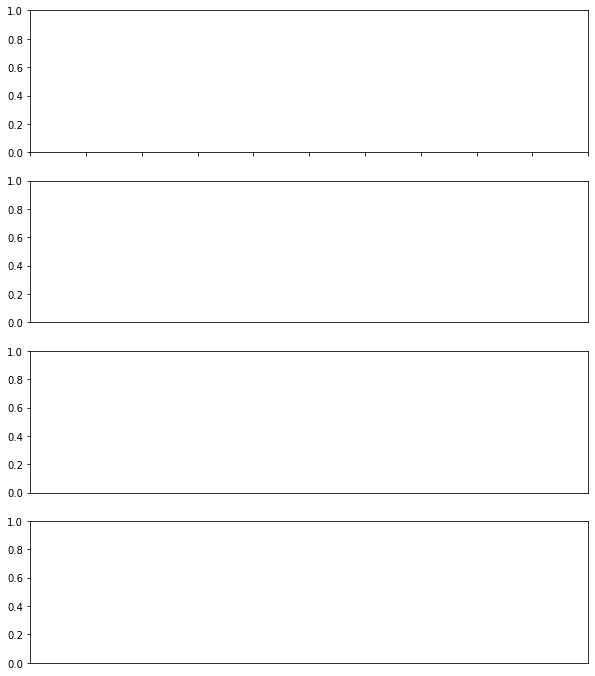

In [43]:
# Monthly temperature anomalies stacked
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(mmm_mon_Glob.tmp, p10_mon_Glob.tmp, p90_mon_Glob.tmp, ax = axes[0], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_SH.tmp, p10_mon_SH.tmp, p90_mon_SH.tmp, ax = axes[1], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_Aus.tmp, p10_mon_Aus.tmp, p90_mon_Aus.tmp, ax = axes[2], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_EA.tmp, p10_mon_EA.tmp, p90_mon_EA.tmp, ax = axes[3], color='lightcoral')

axes[0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[1].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[3].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Eastern Australia')

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

# plt.savefig('R_timeseries_mon_tmp_stacked.png', dpi=300, bbox_inches='tight')